In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
import numpy as np
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline
import pygmo as pg
from pygmo import algorithm
import os
import sys
import json

import time
import numpy as np
from random import shuffle

In [26]:
from math import pi,sqrt,pow

# Table constants
earth_moon_distance = 384400.0 # km
moon_orbit_duration = 27.322 # days
earth_radius = 6367.4447 # km
earth_mass = 5.9721986e24
moon_mass = 7.34767309e22
G = 6.67384e-11 # m^3 kg^-1 s^-2
moon_radius = 1737.1 # km
leo_radius = 160.0+earth_radius # km
llo_radius = 100.0+moon_radius # km
orbit_range = 10.0 # km
day = 24.0*3600.0 # s

# Units
unit_len = earth_moon_distance # km
unit_time = moon_orbit_duration/(2.0*pi) # days
unit_vel = unit_len/(unit_time*day) # km/s

# Gravitational constants
k = moon_mass/(earth_mass+moon_mass) # 1

# Calculation constants
leo_vel = sqrt(G*earth_mass/(leo_orbit*1000.0))/1000.0 # km/s
lunar_orbit_vel = sqrt(G*moon_mass/(lunar_orbit*1000.0))/1000.0 # km/s
moon_pos_x = 1-mu
earth_pos_x = -mu
L1_pos_x = (1-pow(mu/3.0,1.0/3.0))


In [17]:
import inspect
import math

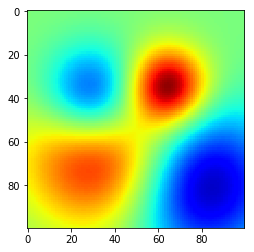

In [13]:
# generate a toy 2D regression dataset
sz = 100
X,Y = np.meshgrid(np.linspace(-1,1,sz),np.linspace(-1,1,sz))
mux,muy,sigma=0.3,-0.3,4
G1 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
mux,muy,sigma=-0.3,0.3,2
G2 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
mux,muy,sigma=0.6,0.6,2
G3 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
mux,muy,sigma=-0.4,-0.2,3
G4 = np.exp(-((X-mux)**2+(Y-muy)**2)/2.0*sigma**2)
G = G1 + G2 - G3 - G4
fig,ax = plt.subplots()
im = ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
#plt.axis('off')

In [40]:
"""
Pdot = generalized momentum, nondimensionalized
"""
def Pdot(x, y, p_x, p_y):
    Pdot_x = - p_y - ((1-k)*(x+k))/((x+k)**2+y**2)**(3/2) + (k*(1+k-x))/((1+k-x)**2+y**2)**(3/2)
    Pdot_y = p_x - ((1-k)*y)/((x+k)**2+y**2)**(3/2) - (k*y)/((1+k-x)**2+y**2)**(3/2)
    return [Pdot_x,Pdot_y]

""" symplectic euler """ 
def euler_step(h, x, y, p_x, p_y):
    v_x = p_x + y
    x = (x + h*(v_x+p_y*h)) / (1.0 + h**2)
    v_y = p_y - x
    y += v_y*h
    
    Pdot_x, Pdot_y = Pdot(x, y, p_x, p_y)
    p_x+=Pdot_x*h
    p_y+=Pdot_y*h
    return x,y,p_x,p_y

def verlet_step(h,x,y,p_x,p_y):
    half_h = h/2
    denominator=1.0/(1+half_h**2)
    
    v_x = p_x-x
    x = (x + half_h*(v_x+p_y*half_h)) * denominator
    v_y = p_y - x
    y+= v_y*half_h
    
    Pdot_x, Pdot_y = Pdot(x, y, p_x, p_y)
    p_x = (p_x+(2.0*Pdot_x+(Pdot_y+Fy)*half_h)*half_h) * denominator
    p_y += (Pdot_y*2)*half_h
    
    v_x = 
    
    

def launch_sim(psi):
    pos_ang, burn_ang, burnDv = psi
    x0 = np.cos(pos_ang) * leo_radius
    y0 = np.sin(pos_ang) * leo_radius
    x0 += earth_pos_x
    
    vhat_x = - np.sin(pos_ang)
    vhat_y = np.cos(pos_ang)
    
    v_x = (leo_vel/unit_vel) * vhat_x
    v_y = (leo_vel/unit_vel) * vhat_y
    
    burnDv_x = np.cos(burn_ang)*vhat_x - np.sin(burn_ang)*vhat_y
    burnDv_y = np.sin(burn_ang)*vhat_x + np.cos(burn_ang)*vhat_y
    
    p0_x = v_x + burnDv*burn_y - y0
    p0_y = v_y + burnDv*burn_x + x0
    
    print(x0,y0,p0_x,p0_y)
    result = Pdot(x0,y0,p0_x,p0_y)
    return result
    #return [G[int(psi[0]),int(psi[1])]]

derp = launch_sim([20,4,100])
derp

2663.7209379470455 5959.199638252225 -5923.754279393595 2757.395466262806


[-2757.395466272384, -5923.754279415022]

In [39]:
class saddle_space:
    def __init__(self):
        self.dim = 2
    
    def fitness(self,psi):
        res = launch_sim(psi)
        return res
    
    def get_bounds(self):
        return ([0,0],[999,999])
    
    def get_name(self):
        return f"saddlespace"
    
    def plot(self, w, idx):
        plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
        x,y = zip(*w)
        plt.scatter(x,y,4,'k',edgecolors='face')
        plt.scatter(w[idx][0],w[idx][1],15,'y',edgecolors='k')

In [ ]:
class salimans_nes:
    def __init__(self,iter=12):
        super(salimans_nes,self).__init__()
        self.prevx,self.prevy = [],[]
        
        self.iter=iter # number of steps towards estimated gradient
    
    def evolve(self,pop):
        if len(pop) == 0:
            return pop
        sigma = 3
        alpha = 0.03 # learningrate
        
        # plotting
        plotting = False
        if plotting:
            plt.figure(figsize=(self.iter,self.iter))
            no_rows = int(self.iter/4+1)
            gs = gridspec.GridSpec(no_rows,4)
            plot_index = 0
        
        #for each iteration, jitter around starting points, and move in the
        #best direction (weighted average jitter coordinates according to 
        #fitness score)
        for i in range(self.iter):
            
            if plotting:
                ax1=plt.subplot(gs[int(i/4),plot_index])
                plot_index += 1
                if plot_index == 4:
                    plot_index = 0
                plt.imshow(G,vmin=-1, vmax=1, cmap='jet')
            
            #get the population    
            wl = pop.get_x()
            
            #do the jittering and selection
            j=0
            for w in wl:
                noise = np.random.randn(200,2)
                wp = [[min(99,max(0,x)),min(99,max(0,y))] for [x,y] in np.expand_dims(w, 0) + sigma*noise]
                
                
                
                if plotting:
                    x,y = zip(*wp)
                    plt.scatter(x,y,4,'k',edgecolors='face')
                R = np.array([prob.fitness(wi)[0] for wi in wp])
                R -= R.mean()
                R /= R.std()
                g = np.dot(R, noise)
                u = alpha * g
                w += u # mutate the population
                w = [min(99,max(0,w[0])),min(99,max(0,w[1]))] # bounds
                pop.set_x(j,w)# make the move previously selected
                j+=1
        return pop

    def get_name(self):
        return f"Oisin's big-dick omegafantastic algorithm"

In [ ]:
def pygmo_es():
    uda = salimans_nes(iter=25)  # user defined algorithm
    udp = saddle_space()  # user defined problem
    prob = pg.problem(udp) # Beautiful white snow

    archi = pg.archipelago(algo=uda, prob=udp, n=50, pop_size=30)
    archi.evolve()
    sols = archi.get_champions_f()
    idx = sols.index(min(sols))
    #print("Done!! Solutions found are: ")
    #print(archi.get_champions_f())
    udp.plot(archi.get_champions_x(),idx)

    #pop = pg.population(prob,10,3)
    #algo.evolve(pop)

In [5]:
sys.path

['',
 'C:\\Users\\oisin\\Anaconda3\\python36.zip',
 'C:\\Users\\oisin\\Anaconda3\\DLLs',
 'C:\\Users\\oisin\\Anaconda3\\lib',
 'C:\\Users\\oisin\\Anaconda3',
 'C:\\Users\\oisin\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\oisin\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\oisin\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\oisin\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\oisin\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\oisin\\.ipython']

In [ ]:
if __name__ == '__main__':
    pygmo_es()

TypeError: 'NoneType' object is not callable